In [2]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
from tensorflow.keras import Sequential
from keras.layers import Dense, LSTM

from datetime import datetime

from modules import binance_data

## Constants

In [3]:
STEP = 128
VALIDATION_SIZE = 0.1

In [4]:
def graph_predictions(training, validation, prediction):
    plt.plot(training[int(len(training)/1.1):], color='blue', label='training') # Getting only last values
    plt.plot(validation, color='red', label='expected')
    plt.plot(prediction, color='black', label='predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

## Import data

In [5]:
start_time = datetime(2020,1,1)
end_time = datetime(2020,6,1)

data = binance_data.get_historical_data('ETHUSDT', '5m', start_time, end_time)

data.head()

,open_time,open,high,low,close,v,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
2020-01-01 00:04:59.999,inf,129.000,129.125,128.875,129.000,447.00,1577833499999,57713.28737640,319,275.88227000,35612.18745840,0
2020-01-01 00:09:59.999,inf,129.000,129.375,129.000,129.000,339.25,1577833799999,43809.13643490,225,151.59562000,19580.74978810,0
2020-01-01 00:14:59.999,inf,129.000,129.250,129.000,129.125,191.25,1577834099999,24704.32736070,188,73.24096000,9462.57059010,0
2020-01-01 00:19:59.999,inf,129.250,129.250,128.875,129.125,469.75,1577834399999,60651.76096350,323,205.17778000,26483.01880880,0
2020-01-01 00:24:59.999,inf,129.125,129.250,128.875,129.000,172.50,1577834699999,22267.10610910,180,79.72585000,10289.36867900,0


## Prepare data

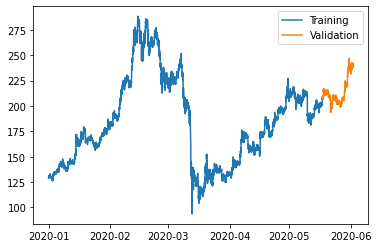

In [6]:
limit = len(data) - int(len(data) * VALIDATION_SIZE)
training_set = data.iloc[:limit, 2:3]
validation_set = data.iloc[limit:, 2:3]

plt.plot(training_set['high'], label='Training')
plt.plot(validation_set['high'], label='Validation')
plt.legend()
plt.show()

In [7]:
# Normalization
sc = MinMaxScaler(feature_range=(0,1))
training_set_norm = sc.fit_transform(training_set)

# Neural net will receive a time serie of n inputs and will predict the following one
X_train = []
Y_train = []
m = len(training_set_norm)

for i in range(0,m-STEP):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(training_set_norm[i:i+STEP,0])
    # Y: el siguiente dato
    Y_train.append(training_set_norm[i+STEP,0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Model training

In [8]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 250
# Model definition
model = Sequential()
model.add(LSTM(units=na, input_shape=dim_entrada))
model.add(Dense(units=dim_salida))
model.compile(optimizer='rmsprop', loss='mse')
# Model training
model.fit(X_train,Y_train,epochs=75,batch_size=16)

Epoch 1/75
2463/2463 [==============================] - 391s 158ms/step - loss: 0.0022
Epoch 2/75
2463/2463 [==============================] - 402s 163ms/step - loss: 1.9131e-04
Epoch 3/75
2463/2463 [==============================] - 360s 146ms/step - loss: 1.1281e-04
Epoch 4/75
2463/2463 [==============================] - 380s 154ms/step - loss: 7.8897e-05
Epoch 5/75
2463/2463 [==============================] - 378s 153ms/step - loss: 6.2951e-05
Epoch 6/75
2463/2463 [==============================] - 358s 145ms/step - loss: 5.3754e-05
Epoch 7/75
2463/2463 [==============================] - 362s 147ms/step - loss: 4.4754e-05
Epoch 8/75
2463/2463 [==============================] - 359s 146ms/step - loss: 4.1244e-05
Epoch 9/75
2463/2463 [==============================] - 358s 145ms/step - loss: 3.7332e-05
Epoch 10/75
2463/2463 [==============================] - 358s 145ms/step - loss: 3.3971e-05
Epoch 11/75
2463/2463 [==============================] - 359s 146ms/step - loss: 3.1817e-05
E

## Model validation

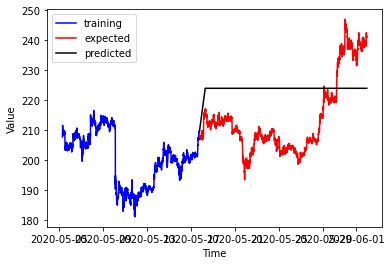

In [9]:
# Empty list to store predicted values
predictions = []

# First prediction
x_test = training_set.values[-STEP:] # Last items of training set
x_test = sc.transform(x_test)        # Nomalize data
x_test = np.expand_dims(x_test, axis=0) # Match expected dimensions
y_prediction = model.predict(x_test) # Predict
predictions.append(y_prediction) # Store prediction

# For further predictions, append last prediction to input data and repeat previous porcess
for i in range(len(validation_set)-1):
    x_test = np.roll(x_test, -1)
    x_test[0,-1,0] = y_prediction
    y_prediction = model.predict(x_test)
    predictions.append(y_prediction)
    
predictions = np.array(predictions)[:, : , 0]   # Delete extra dimensions
predictions = sc.inverse_transform(predictions) # Denormalize data

# Insert predictions into validation dataframe, to datetime indexes
validation_set['prediction'] = predictions

graph_predictions(training_set['high'], validation_set['high'], validation_set['prediction'])



In [10]:
validation_set['error'] = abs(validation_set['high'] - validation_set['prediction'])
validation_set.head(15)

,high,prediction,error
2020-05-17 18:09:59.999,208.875,209.524445,0.649445
2020-05-17 18:14:59.999,208.750,209.672195,0.922195
2020-05-17 18:19:59.999,208.750,209.765854,1.015854
2020-05-17 18:24:59.999,208.500,209.853210,1.353210
2020-05-17 18:29:59.999,208.375,209.943924,1.568924
2020-05-17 18:34:59.999,208.500,210.038269,1.538269
2020-05-17 18:39:59.999,208.250,210.133881,1.883881
2020-05-17 18:44:59.999,207.750,210.229721,2.479721
2020-05-17 18:49:59.999,207.625,210.325424,2.700424
2020-05-17 18:54:59.999,207.625,210.420975,2.795975


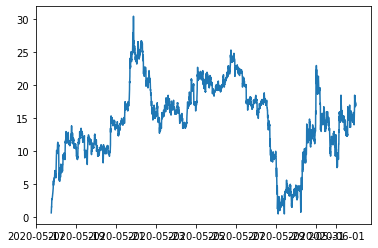

In [11]:
plt.plot(validation_set['error'])
plt.show()